# Regression Model Development
**Victor Huarniz**
**Linkedin: https://www.linkedin.com/in/victor-h-noya/**

**DAT-5303 | Machine Learning**
**Professor: Chase Kusterer**
**Hult International Business School**

### Purpose of this Script

This script is designed to run different models and get the most accurate model which will be determined by the highest R-squared and lowest Train-Test Gap which cannot be above 0.05 as our confidence level for our model will be 95%. This means that we can be assure that 95% of the times the model will represent accurately the relationship of the dependent variables to explain the independent variable (Revenue). Other assumptions include a random_state of 219 and a test_size of 0.25.<br>

Our steps include:<br>
~~~
1) Reading and massaging dataset 
2) Creating and evaluating models 
    2.1) OLS Regression (standard linear regression) 
    2.2) Lasso Regression 
    2.3) Bayesian Automatic Relevance Determination (ARD)
    2.4) K-Nearest Neighbors Regression (KNN) 
3) Summarize the models of choose of the optimal model considering metrics
~~~

## Reading and massaging dataset

### Reading packages and data

In [1]:
## Importing packages
# importing essential libraries
import pandas as pd  # data science essentials
import matplotlib.pyplot as plt  # essential graphical output
import numpy as np  # essential math
import seaborn as sns  # enhanced graphical output
import statsmodels.formula.api as smf  # regression modeling

# import packages for massaging
import gender_guesser.detector as gender  # to guess gender of names

# import packages for the models
from sklearn.model_selection import train_test_split  # train/test split
import sklearn.linear_model  # linear Models (scikit-learn) (OLS, Lasso, ARD)
from sklearn.neighbors import KNeighborsRegressor  # KNN for Regression
from sklearn.preprocessing import StandardScaler  # standard scaler

## Reading datasets
# setting pandas print options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# specifying file names
dataset_file = './data/Apprentice_Chef_Dataset.xlsx'
dictionary_file = './data/Apprentice_Chef_Data_Dictionary.xlsx'
#performance_file = './model_results/linear_model_performance.xlsx'
#prediction_file  = './model_results/linear_model_predictions.xlsx'

# reading the files into Python
chef = pd.read_excel(dataset_file)
dictionary = pd.read_excel(dictionary_file)
#performance = pd.read_excel(performance_file)
#predictions = pd.read_excel(prediction_file)

### Massaging data

In [2]:
## creating a copy of the original data set: "chef_new"

chef_new = chef.copy()

########################################################################################################################
########################################################################################################################
########################################################################################################################

## Renaming variables
# LARGEST_ORDER_SIZE -> AVG_ORDER_SIZE

chef_new.rename(columns={'LARGEST_ORDER_SIZE': 'AVG_ORDER_SIZE'}, inplace=True)

# MOBILE_NUMBER -> HAVE_MOBILE_NUMBER

chef_new.rename(columns={'MOBILE_NUMBER': 'HAVE_MOBILE_NUMBER'}, inplace=True)

########################################################################################################################
########################################################################################################################
########################################################################################################################

## Classifying personal and work emails by domain

# placeholder list
placeholder_lst = []

# looping over each email address
for index, col in chef_new.iterrows():

    # splitting email domain at '@'
    split_email = chef_new.loc[index, 'EMAIL'].split(sep="@")

    # appending placeholder_lst with the results
    placeholder_lst.append(split_email)

# converting placeholder_lst into a DataFrame
email_df = pd.DataFrame(placeholder_lst)

# renaming column to concatenate
email_df.columns = ['0', 'email_domain']

# concatenating personal_email_domain with friends DataFrame
chef_new = pd.concat([chef_new, email_df['email_domain']], axis=1)

# email domain types
personal_email_domains = [
    '@gmail.com', '@hotmail.com', '@live.com', '@me.com', '@yahoo.com',
    '@msn.com', '@protonmail.com'
]

# placeholder list
placeholder_lst = []

# looping to group observations by domain type
for domain in chef_new['email_domain']:
    if "@" + domain in personal_email_domains:
        placeholder_lst.append('personal')

    else:
        placeholder_lst.append('worker')

# concatenating with original DataFrame
chef_new['domain_group'] = pd.Series(placeholder_lst)

########################################################################################################################
########################################################################################################################
########################################################################################################################

## New columns to define new variables from other columns

# "EFF_CLICKS_ABV_MEAN" Show if clicks above average give more orders: if above average -> orders/clicks

# looping over each email address
for index, value in chef_new.iterrows():

    #conditional to get a dummy if clicks above average:

    if chef_new.loc[
            index,
            'AVG_CLICKS_PER_VISIT'] > chef_new['AVG_CLICKS_PER_VISIT'].mean():
        chef_new.loc[index, 'EFF_CLICKS_ABV_MEAN'] = chef_new.loc[
            index,
            'TOTAL_MEALS_ORDERED'] / chef_new.loc[index,
                                                  'AVG_CLICKS_PER_VISIT']
    else:
        chef_new.loc[index, 'EFF_CLICKS_ABV_MEAN'] = 0

# "EFF_CLICKS_BELOW_MEAN" Show if clicks above average give more orders: if below or equal average -> orders/clicks

# looping over each email address
for index, value in chef_new.iterrows():

    #conditional to get a dummy if clicks above average:

    if chef_new.loc[
            index,
            'AVG_CLICKS_PER_VISIT'] <= chef_new['AVG_CLICKS_PER_VISIT'].mean():
        chef_new.loc[index, 'EFF_CLICKS_BELOW_MEAN'] = chef_new.loc[
            index,
            'TOTAL_MEALS_ORDERED'] / chef_new.loc[index,
                                                  'AVG_CLICKS_PER_VISIT']
    else:
        chef_new.loc[index, 'EFF_CLICKS_BELOW_MEAN'] = 0

# "HIGH_CUSTOMER_SERVICE" Efficiency of customer service (if above median, bad):

# looping over CUSTOMER_SERVICE
for index, value in chef_new.iterrows():

    #conditional to get a dummy if clicks above average:

    if chef_new.loc[index, 'CONTACTS_W_CUSTOMER_SERVICE'] >= chef_new[
            'CONTACTS_W_CUSTOMER_SERVICE'].median():
        chef_new.loc[index, 'HIGH_CUSTOMER_SERVICE'] = 1
    else:
        chef_new.loc[index, 'HIGH_CUSTOMER_SERVICE'] = 0

# "PC_FAN" Efficiency of PC_LOGINS (if above median, fan):

# looping over PC_LOGINS
for index, value in chef_new.iterrows():

    #conditional to get a dummy if clicks above average:

    if chef_new.loc[index, 'PC_LOGINS'] >= chef_new['PC_LOGINS'].median():
        chef_new.loc[index, 'PC_FAN'] = 1
    else:
        chef_new.loc[index, 'PC_FAN'] = 0

########################################################################################################################
########################################################################################################################
########################################################################################################################

## Creating new variables

# "EFF_PC_PLATFORM" Efficiency of categories: HAVE_MOBILE_NUMBER * PC_LOGINS

chef_new[
    'EFF_PC_PLATFORM'] = chef_new['HAVE_MOBILE_NUMBER'] * chef_new['PC_LOGINS']

# "EFF_CATEGORIES" Efficiency of categories: TOTAL_MEALS_ORDERED / PRODUCT_CATEGORIES_VIEWED

chef_new['EFF_CATEGORIES'] = chef_new['TOTAL_MEALS_ORDERED'] / chef_new[
    'PRODUCT_CATEGORIES_VIEWED']

# "EFF_CROSS_SALE_PROMOTION" Efficiency of cross sell promotions: TOTAL_MEALS_ORDERED * CROSS_SELL_SUCCESS

chef_new['EFF_CROSS_SALE_PROMOTION'] = chef_new[
    'TOTAL_MEALS_ORDERED'] * chef_new['CROSS_SELL_SUCCESS']

########################################################################################################################
########################################################################################################################
########################################################################################################################

## Get dummies variables for categorical variables

# one hot encoding categorical variables
one_hot_cross_sell = pd.get_dummies(chef_new['CROSS_SELL_SUCCESS'])
one_hot_mobile_number = pd.get_dummies(chef_new['HAVE_MOBILE_NUMBER'])
one_hot_taste_info = pd.get_dummies(chef_new['TASTES_AND_PREFERENCES'])
one_hot_package_locker = pd.get_dummies(chef_new['PACKAGE_LOCKER'])
one_hot_refrigerated_locker = pd.get_dummies(chef_new['REFRIGERATED_LOCKER'])
one_hot_rating = pd.get_dummies(chef_new['MEDIAN_MEAL_RATING'])
one_hot_classes = pd.get_dummies(chef_new['MASTER_CLASSES_ATTENDED'])
one_hot_domain = pd.get_dummies(chef_new['domain_group'])

# labels

one_hot_cross_sell.columns = ['CROSS_SELL_0', 'CROSS_SELL_1']
one_hot_mobile_number.columns = ['MOBILE_NUMBER_0', 'MOBILE_NUMBER_1']
one_hot_taste_info.columns = ['TASTES_0', 'TASTES_1']
one_hot_package_locker.columns = ['PACKAGE_LOCKER_0', 'PACKAGE_LOCKER_1']
one_hot_refrigerated_locker.columns = [
    'REFRIGERATED_LOCKER_0', 'REFRIGERATED_LOCKER_1'
]
one_hot_rating.columns = [
    'RATING_1', 'RATING_2', 'RATING_3', 'RATING_4', 'RATING_5'
]
one_hot_classes.columns = ['CLASSES_0', 'CLASSES_1', 'CLASSES_2', 'CLASSES_3']
one_hot_domain.columns = ['PERSONAL_EMAIL', 'WORK_EMAIL']

# dropping categorical variables after they've been encoded
chef_new = chef_new.drop('CROSS_SELL_SUCCESS', axis=1)
chef_new = chef_new.drop('HAVE_MOBILE_NUMBER', axis=1)
chef_new = chef_new.drop('TASTES_AND_PREFERENCES', axis=1)
chef_new = chef_new.drop('PACKAGE_LOCKER', axis=1)
chef_new = chef_new.drop('REFRIGERATED_LOCKER', axis=1)
chef_new = chef_new.drop('MEDIAN_MEAL_RATING', axis=1)
chef_new = chef_new.drop('MASTER_CLASSES_ATTENDED', axis=1)
chef_new = chef_new.drop('domain_group', axis=1)

# joining codings together
chef_new = chef_new.join([
    one_hot_cross_sell, one_hot_mobile_number, one_hot_taste_info,
    one_hot_package_locker, one_hot_refrigerated_locker, one_hot_rating,
    one_hot_classes, one_hot_domain
])

# saving new columns
new_columns = chef_new.columns

# creating a (Pearson) correlation matrix
chef_corr = chef_new.corr().round(2)

# printing (Pearson) correlations with SalePrice
print(chef_corr.loc['REVENUE'].sort_values(ascending=False))

########################################################################################################################
########################################################################################################################
########################################################################################################################

# New variables from dummies

# "GOOD_ORDERS". Number of orders with 4 or 5 stars:

for index, value in chef_new.iterrows():

    #conditional to get a dummy if clicks above average:

    if chef_new.loc[index, 'RATING_4']+chef_new.loc[index, 'RATING_5']   >= 1:
        chef_new.loc[index, 'GOOD_ORDERS'] = 1
    else:
        chef_new.loc[index, 'GOOD_ORDERS'] = 0

# "GO_TO_CLASS". Number of people that attend at least one class:

for index, value in chef_new.iterrows():

    #conditional to get a dummy if clicks above average:

    if chef_new.loc[index, 'CLASSES_1'] + chef_new.loc[
            index, 'CLASSES_2'] +chef_new.loc[index, 'CLASSES_3'] >= 1:
        chef_new.loc[index, 'GO_TO_CLASS'] = 1
    else:
        chef_new.loc[index, 'GO_TO_CLASS'] = 0

# droping names

chef_new = chef_new.drop([
    'NAME', 'EMAIL', 'FIRST_NAME', 'FAMILY_NAME', 'email_domain',
    'CROSS_SELL_0', 'MOBILE_NUMBER_0', 'PACKAGE_LOCKER_0', 'WORK_EMAIL',
    'REFRIGERATED_LOCKER_1','REFRIGERATED_LOCKER_0','EARLY_DELIVERIES','CROSS_SELL_1','RATING_3'
    ,'EFF_PC_PLATFORM','MOBILE_NUMBER_1','PRODUCT_CATEGORIES_VIEWED','PC_LOGINS','PC_FAN',
    'TASTES_1','CANCELLATIONS_BEFORE_NOON','WEEKLY_PLAN','PACKAGE_LOCKER_1','LATE_DELIVERIES','TASTES_0','PERSONAL_EMAIL',
    'MOBILE_LOGINS','CANCELLATIONS_AFTER_NOON','CLASSES_3','CLASSES_2','CLASSES_1'
],
                         axis=1)

REVENUE                        1.00
AVG_PREP_VID_TIME              0.64
EFF_CLICKS_BELOW_MEAN          0.62
TOTAL_MEALS_ORDERED            0.60
RATING_4                       0.59
TOTAL_PHOTOS_VIEWED            0.47
AVG_ORDER_SIZE                 0.44
EFF_CROSS_SALE_PROMOTION       0.39
EFF_CATEGORIES                 0.36
CLASSES_1                      0.33
HIGH_CUSTOMER_SERVICE          0.27
CLASSES_2                      0.22
AVG_TIME_PER_SITE_VISIT        0.14
CONTACTS_W_CUSTOMER_SERVICE    0.10
RATING_5                       0.04
EFF_PC_PLATFORM                0.04
MOBILE_NUMBER_1                0.03
CLASSES_3                      0.03
PRODUCT_CATEGORIES_VIEWED      0.03
PC_LOGINS                      0.02
PC_FAN                         0.02
WEEKLY_PLAN                    0.01
PACKAGE_LOCKER_0               0.01
TASTES_1                       0.01
WORK_EMAIL                     0.01
CANCELLATIONS_BEFORE_NOON      0.01
CROSS_SELL_1                   0.00
RATING_3                    

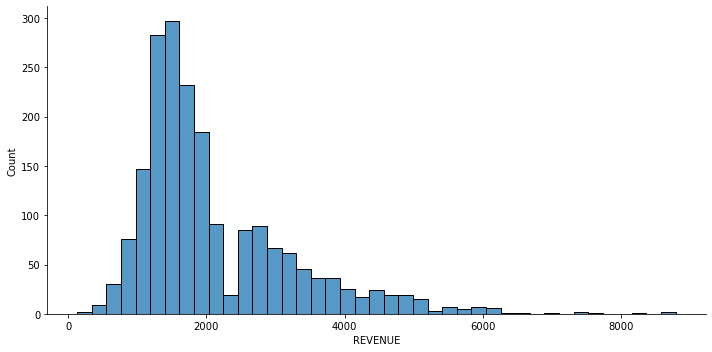

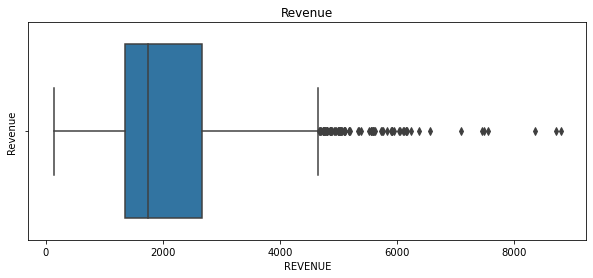

In [3]:
# developing a histogram using DISPLOT
sns.displot(data=chef_new, x="REVENUE", height=5, aspect=2)

# displaying the histogram
plt.show()

# setting figure size
fig, ax = plt.subplots(figsize=(10, 4))

## REVENUE ##

# developing a boxplot
sns.boxplot(x='REVENUE', data=chef_new)

# titles and labels
plt.title(label='Revenue')
plt.ylabel(ylabel='Revenue')
plt.tight_layout
plt.show()

## Creating and evaluating models
### Preparing training and testing data

In [4]:
## Setting response variable (y = REVENUE)

chef_target = chef_new.loc[:, 'REVENUE']

chef_new['log_REVENUE'] = np.log10(chef_new['REVENUE'])

chef_target_log = chef_new.loc[:, 'log_REVENUE']

# Setting explanatory variables (x)
chef_data = chef_new.drop(['REVENUE', 'log_REVENUE'], axis=1)

x_variables = list(chef_data.columns)

# Setting up train-test split
x_train, x_test, y_train, y_test = train_test_split(
    chef_data,  # x-variables
    chef_target,  # y-variable
    test_size=0.25,
    random_state=219)

print(f"""
Training Data
-------------
X-side: {x_train.shape}
y-side: {y_train.shape}


Testing Data
------------
X-side: {x_test.shape}
y-side: {y_test.shape}
""")

## Standarized data

# INSTANTIATING a StandardScaler() object
scaler = StandardScaler()

# FITTING the scaler with chef_data
scaler.fit(chef_data)

# TRANSFORMING our data after fit
x_scaled = scaler.transform(chef_data)

# converting scaled data into a DataFrame
x_scaled_df = pd.DataFrame(x_scaled)

# adding labels to the scaled DataFrame
x_scaled_df.columns = chef_data.columns

# Setting up STANDARD train-test split

x_train_STAND, x_test_STAND, y_train_STAND, y_test_STAND = train_test_split(
    x_scaled_df, chef_target, test_size=0.25, random_state=219)


Training Data
-------------
X-side: (1459, 20)
y-side: (1459,)


Testing Data
------------
X-side: (487, 20)
y-side: (487,)



### OLS Regression

In [5]:
# INSTANTIATING a model object
lr = sklearn.linear_model.LinearRegression()

# FITTING to the training data
lr_fit = lr.fit(x_train, y_train)

# PREDICTING on new data
lr_pred = lr_fit.predict(x_test)

# SCORING the results
print('OLS Training Score :',
      lr.score(x_train, y_train).round(4))  # using R-square
print('OLS Testing Score  :',
      lr.score(x_test, y_test).round(4))  # using R-square

lr_train_score = lr.score(x_train, y_train).round(4)
lr_test_score = lr.score(x_test, y_test).round(4)

# displaying and saving the gap between training and testing
print('OLS Train-Test Gap :', abs(lr_train_score - lr_test_score).round(4))
lr_test_gap = abs(lr_train_score - lr_test_score).round(4)

# zipping each feature name to its coefficient
lr_model_values = zip(chef_data[x_variables].columns,
                      lr_fit.coef_.round(decimals=2))

# setting up a placeholder list to store model features
lr_model_lst = [('intercept', lr_fit.intercept_.round(decimals=2))]

# dropping coefficients that are equal to zero

for feature, coefficient in lr_model_lst:
    if int(coefficient) == 0:
        lr_model_lst.remove((feature, coefficient))

# printing out each feature-coefficient pair one by one
for val in lr_model_values:
    lr_model_lst.append(val)

OLS Training Score : 0.6577
OLS Testing Score  : 0.6999
OLS Train-Test Gap : 0.0422


### Lasso Regression

In [6]:
# INSTANTIATING a model object
lasso_model = sklearn.linear_model.Lasso(alpha=0.01, normalize=True)

# FITTING to the training data
lasso_model_fit = lasso_model.fit(x_train, y_train)

# PREDICTING on new data
lasso_model_pred = lasso_model_fit.predict(x_test)

# SCORING the results
print('Lasso Model Training Score :',
      lasso_model.score(x_train, y_train).round(4))  # using R-square
print('Lasso Model Testing Score  :',
      lasso_model.score(x_test, y_test).round(4))  # using R-square

lasso_model_train_score = lasso_model.score(x_train, y_train).round(4)
lasso_model_test_score = lasso_model.score(x_test, y_test).round(4)

# displaying and saving the gap between training and testing
print('Lasso Model Train-Test Gap :',
      abs(lasso_model_train_score - lasso_model_test_score).round(4))
lasso_model_test_gap = abs(lasso_model_train_score -
                           lasso_model_test_score).round(4)

# zipping each feature name to its coefficient
lasso_model_values = zip(chef_data[x_variables].columns,
                         lasso_model_fit.coef_.round(decimals=2))

# setting up a placeholder list to store model features
lasso_model_lst = [('intercept', lasso_model_fit.intercept_.round(decimals=2))]

# printing out each feature-coefficient pair one by one
for val in lasso_model_values:
    lasso_model_lst.append(val)

# dropping coefficients that are equal to zero
for feature, coefficient in lasso_model_lst:
    if int(coefficient) == 0:
        lasso_model_lst.remove((feature, coefficient))

Lasso Model Training Score : 0.6577
Lasso Model Testing Score  : 0.6999
Lasso Model Train-Test Gap : 0.0422


### Bayesian Automatic Relevance Determination (ARD)

In [7]:
# INSTANTIATING a model object
ard_model = sklearn.linear_model.ARDRegression()

# FITTING the training data
ard_fit = ard_model.fit(x_train, y_train)

# PREDICTING on new data
ard_pred = ard_fit.predict(x_test)

print('ARD Training Score:', ard_model.score(x_train, y_train).round(4))
print('ARD Testing Score :', ard_model.score(x_test, y_test).round(4))

# saving scoring data for future use
ard_train_score = ard_model.score(x_train, y_train).round(4)
ard_test_score = ard_model.score(x_test, y_test).round(4)

# displaying and saving the gap between training and testing
print('ARD Train-Test Gap :', abs(ard_train_score - ard_test_score).round(4))
ard_test_gap = abs(ard_train_score - ard_test_score).round(4)

# zipping each feature name to its coefficient
ard_model_values = zip(chef_data.columns, ard_fit.coef_.round(decimals=2))

# setting up a placeholder list to store model features
ard_model_lst = [('intercept', ard_fit.intercept_.round(decimals=2))]

# printing out each feature-coefficient pair one by one
for val in ard_model_values:
    ard_model_lst.append(val)

# dropping coefficients that are equal to zero
for feature, coefficient in ard_model_lst:
    if int(coefficient) == 0:
        ard_model_lst.remove((feature, coefficient))

ARD Training Score: 0.657
ARD Testing Score : 0.7008
ARD Train-Test Gap : 0.0438


### K-Nearest Neighbors Regression (KNN) 

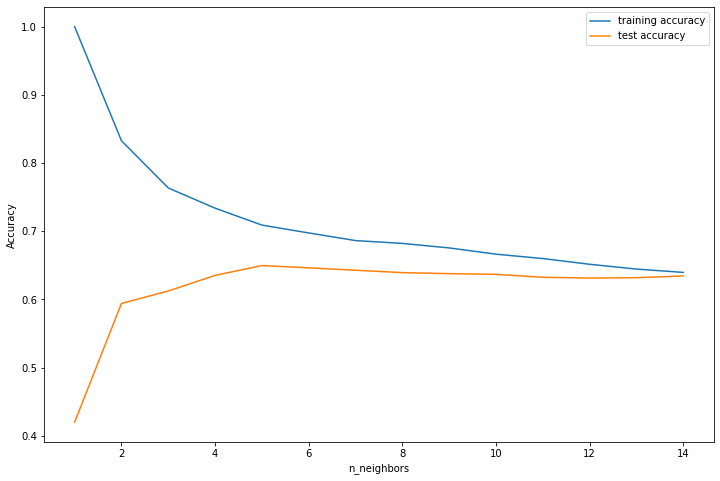

The optimal number of neighbors is 7
KNN Training Score: 0.6863
KNN Testing Score : 0.6428
KNN Train-Test Gap: 0.0435


In [8]:
# creating lists for training set accuracy and test set accuracy
training_accuracy = []
test_accuracy = []
gap = []

# building a visualization of 1 to 15 neighbors
neighbors_settings = range(1, 15)

for n_neighbors in neighbors_settings:
    # Building the model
    clf = KNeighborsRegressor(n_neighbors=n_neighbors, p=1)
    clf.fit(x_train, y_train)

    # Recording the training set accuracy
    training_accuracy.append(clf.score(x_train, y_train))

    # Recording the generalization accuracy
    test_accuracy.append(clf.score(x_test, y_test))

    # Recording the gap
    gap.append(clf.score(x_train, y_train) - clf.score(x_test, y_test))

# plotting the visualization
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()
plt.show()

opt_neighbors = test_accuracy.index(max(test_accuracy)) + 1
while gap[opt_neighbors - 1] >= 0.05:
    opt_neighbors = test_accuracy.index(max(test_accuracy[opt_neighbors:])) + 1

print(f"""The optimal number of neighbors is {opt_neighbors}""")

###############################################################
# INSTANTIATING a model with the optimal number of neighbors
knn_opt = KNeighborsRegressor(algorithm='auto', n_neighbors=opt_neighbors, p=1)

# FITTING the model based on the training data
knn_opt_fit = knn_opt.fit(x_train, y_train)

# PREDITCING on new data
knn_opt_pred = knn_opt_fit.predict(x_test)

# SCORING the results
print('KNN Training Score:', knn_opt.score(x_train, y_train).round(4))
print('KNN Testing Score :', knn_opt.score(x_test, y_test).round(4))

# saving scoring data for future use
knn_opt_score_train = knn_opt.score(x_train, y_train).round(4)
knn_opt_score_test = knn_opt.score(x_test, y_test).round(4)

# displaying and saving the gap between training and testing
print('KNN Train-Test Gap:',
      abs(knn_opt_score_train - knn_opt_score_test).round(4))
knn_opt_test_gap = abs(knn_opt_score_train - knn_opt_score_test).round(4)

### Standarized K-Nearest Neighbors Regression (KNN) 

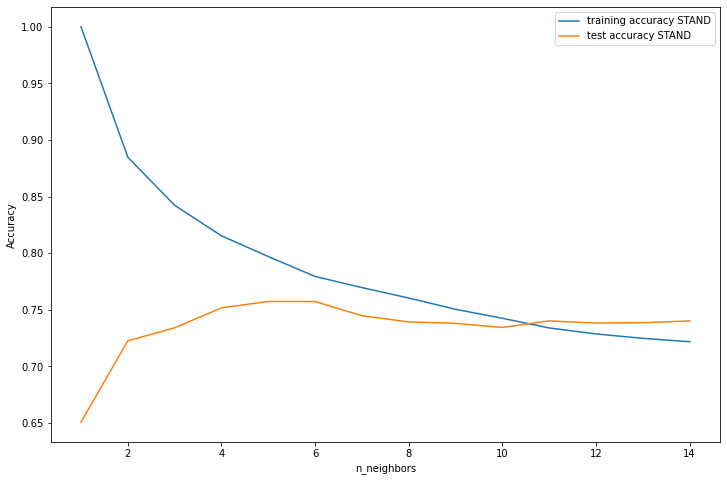

The optimal number of neighbors is 5
KNN Training Score STAND: 0.797
KNN Testing Score STAND: 0.7574
KNN Train-Test Gap STAND: 0.0396


In [9]:
# creating lists for training set accuracy and test set accuracy
training_accuracy_STAND = []
test_accuracy_STAND = []
gap_STAND = []

# building a visualization of 1 to 15 neighbors
neighbors_settings_STAND = range(1, 15)

for n_neighbors in neighbors_settings_STAND:
    # Building the model
    clf_STAND = KNeighborsRegressor(n_neighbors=n_neighbors, p=1)
    clf_STAND.fit(x_train_STAND, y_train_STAND)

    # Recording the training set accuracy
    training_accuracy_STAND.append(
        clf_STAND.score(x_train_STAND, y_train_STAND))

    # Recording the generalization accuracy
    test_accuracy_STAND.append(clf_STAND.score(x_test_STAND, y_test_STAND))

    # Recording the gap
    gap_STAND.append(
        clf_STAND.score(x_train_STAND, y_train_STAND) -
        clf_STAND.score(x_test_STAND, y_test_STAND))

# plotting the visualization
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(neighbors_settings_STAND,
         training_accuracy_STAND,
         label="training accuracy STAND")
plt.plot(neighbors_settings_STAND,
         test_accuracy_STAND,
         label="test accuracy STAND")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()
plt.show()

opt_neighbors_STAND = test_accuracy_STAND.index(max(test_accuracy_STAND)) + 1
while gap_STAND[opt_neighbors_STAND - 1] >= 0.05:
    opt_neighbors_STAND = test_accuracy_STAND.index(
        max(test_accuracy_STAND[opt_neighbors_STAND:])) + 1

print(f"""The optimal number of neighbors is {opt_neighbors_STAND}""")

###############################################################
# INSTANTIATING a model with the optimal number of neighbors
knn_opt_STAND = KNeighborsRegressor(algorithm='auto',
                                    p=1,
                                    n_neighbors=opt_neighbors_STAND)

# FITTING the model based on the training data
knn_opt_fit_STAND = knn_opt_STAND.fit(x_train_STAND, y_train_STAND)

# PREDITCING on new data
knn_opt_pred_STAND = knn_opt_fit_STAND.predict(x_test_STAND)

# SCORING the results
print('KNN Training Score STAND:',
      knn_opt_STAND.score(x_train_STAND, y_train_STAND).round(4))
print('KNN Testing Score STAND:',
      knn_opt_STAND.score(x_test_STAND, y_test_STAND).round(4))

# saving scoring data for future use
knn_opt_score_train_STAND = knn_opt_STAND.score(x_train_STAND,
                                                y_train_STAND).round(4)
knn_opt_score_test_STAND = knn_opt_STAND.score(x_test_STAND,
                                               y_test_STAND).round(4)

# displaying and saving the gap between training and testing
print('KNN Train-Test Gap STAND:',
      abs(knn_opt_score_train_STAND - knn_opt_score_test_STAND).round(4))
knn_opt_test_gap_STAND = abs(knn_opt_score_train_STAND -
                             knn_opt_score_test_STAND).round(4)

## Summarize the models of choose of the optimal model considering metrics
### Comparing results

In [10]:
# comparing results

print(f"""
Model      Train Score      Test Score      Train-Test Gap     Model Size      Model
-----      -----------      ----------      --------------      ----------      -----------                         
OLS        {lr_train_score}            {lr_test_score}            {lr_test_gap}            {len(lr_model_lst)}            {lr_model_lst}
------------------------------------------------------------------------------------------------------------
Lasso      {lasso_model_train_score}           {lasso_model_test_score}            {lasso_model_test_gap}            {len(lasso_model_lst)}            {lasso_model_lst}
------------------------------------------------------------------------------------------------------------
ARD        {ard_train_score}           {ard_test_score}            {ard_test_gap}            {len(ard_model_lst)}            {ard_model_lst}
------------------------------------------------------------------------------------------------------------
KNN        {knn_opt_score_train}           {knn_opt_score_test}            {knn_opt_test_gap}            {opt_neighbors}            "NA"
------------------------------------------------------------------------------------------------------------
KNN_STAND  {knn_opt_score_train_STAND}           {knn_opt_score_test_STAND}            {knn_opt_test_gap_STAND}            {opt_neighbors_STAND}            "NA"
""")

# creating a dictionary for model results
model_performance = {
    'Model Type': ['OLS', 'Lasso', 'ARD', 'KNN', 'KNN_STAND'],
    'Training': [
        lr_train_score, lasso_model_train_score, ard_train_score,
        knn_opt_score_train, knn_opt_score_train_STAND
    ],
    'Testing': [
        lr_test_score, lasso_model_test_score, ard_test_score,
        knn_opt_score_test, knn_opt_score_test_STAND
    ],
    'Train-Test Gap': [
        lr_test_gap, lasso_model_test_gap, ard_test_gap, knn_opt_test_gap,
        knn_opt_test_gap_STAND
    ],
    'Model Size': [
        len(lr_model_lst),
        len(lasso_model_lst),
        len(ard_model_lst), opt_neighbors, opt_neighbors_STAND
    ],
    'Model': [lr_model_lst, lasso_model_lst, ard_model_lst, "NA", "NA"]
}

# converting model_performance into a DataFrame
model_performance = pd.DataFrame(model_performance)

# creating dataframe with all predicted values
predictions = pd.DataFrame(
    data={
        'Original Sale Prices': y_test,
        'LR Predictions': lr_pred.round(decimals=2),
        'Lasso Predictions': lasso_model_pred.round(decimals=2),
        'ARD Predictions': ard_pred.round(decimals=2),
        'KNN Predictions': knn_opt_pred.round(decimals=2),
        'KNN Stand Predictions': knn_opt_pred_STAND.round(decimals=2),
        'LR Deviation': lr_pred.round(decimals=2) - y_test,
        'Lasso Deviation': lasso_model_pred.round(decimals=2) - y_test,
        'ARD Deviation': ard_pred.round(decimals=2) - y_test,
        'KNN Deviation': knn_opt_pred.round(decimals=2) - y_test,
        'KNN Stand Deviation': knn_opt_pred_STAND.round(decimals=2) - y_test
    })

# sending model results to Excel
model_performance.to_excel('linear_model_performance.xlsx', index=False)

# sending predictions to Excel

predictions.to_excel('predictions.xlsx', index=False)


Model      Train Score      Test Score      Train-Test Gap     Model Size      Model
-----      -----------      ----------      --------------      ----------      -----------                         
OLS        0.6577            0.6999            0.0422            21            [('intercept', 1201.76), ('TOTAL_MEALS_ORDERED', 4.67), ('UNIQUE_MEALS_PURCH', -67.01), ('CONTACTS_W_CUSTOMER_SERVICE', -27.31), ('AVG_TIME_PER_SITE_VISIT', -0.82), ('AVG_PREP_VID_TIME', 9.45), ('AVG_ORDER_SIZE', -113.9), ('AVG_CLICKS_PER_VISIT', -1.62), ('TOTAL_PHOTOS_VIEWED', 0.47), ('EFF_CLICKS_ABV_MEAN', 0.51), ('EFF_CLICKS_BELOW_MEAN', 7.43), ('HIGH_CUSTOMER_SERVICE', 242.64), ('EFF_CATEGORIES', 0.79), ('EFF_CROSS_SALE_PROMOTION', -0.5), ('RATING_1', -316.27), ('RATING_2', -217.86), ('RATING_4', 596.04), ('RATING_5', -352.12), ('CLASSES_0', -107.6), ('GOOD_ORDERS', 243.92), ('GO_TO_CLASS', 107.6)]
------------------------------------------------------------------------------------------------------------

### Winning model and analysis
Following our last summary table, we can conclude that Standarized KNN has the highest testing score with the following metrics:

In [11]:
print(f"""
Model      Train Score      Test Score      Train-Test Gap     Model Size      Model
-----      -----------      ----------      --------------      ----------      -----------    
KNN_STAND  {knn_opt_score_train_STAND}           {knn_opt_score_test_STAND}            {knn_opt_test_gap_STAND}               {ard_model_lst}
""")


Model      Train Score      Test Score      Train-Test Gap     Model Size      Model
-----      -----------      ----------      --------------      ----------      -----------    
KNN_STAND  0.797           0.7574            0.0396               [('intercept', 1108.97), ('TOTAL_MEALS_ORDERED', 4.99), ('UNIQUE_MEALS_PURCH', -67.09), ('CONTACTS_W_CUSTOMER_SERVICE', -17.5), ('AVG_PREP_VID_TIME', 9.38), ('AVG_ORDER_SIZE', -110.03), ('TOTAL_PHOTOS_VIEWED', 0.45), ('EFF_CLICKS_BELOW_MEAN', 3.04), ('HIGH_CUSTOMER_SERVICE', 205.81), ('EFF_CROSS_SALE_PROMOTION', -0.13), ('RATING_1', -319.5), ('RATING_2', -228.48), ('RATING_4', 862.62), ('CLASSES_0', -106.62), ('GO_TO_CLASS', 106.62)]



However, we can compare all models predictions with their original values and appreciate that they include most of the original values within the IQR. Although the median seems a bit over inflated, therefore we should expect a lower real revenue than the one predicted.

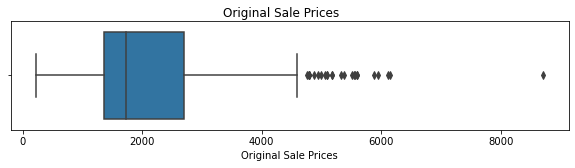

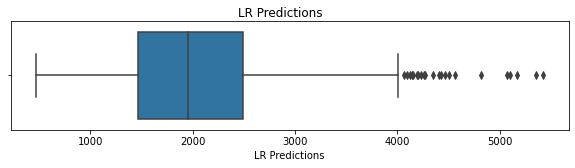

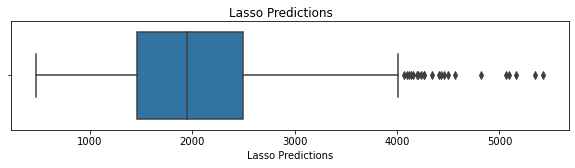

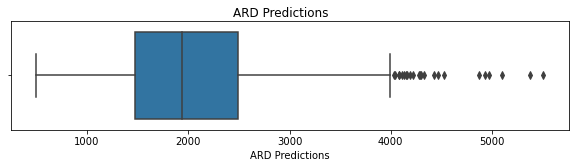

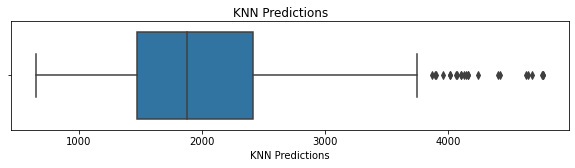

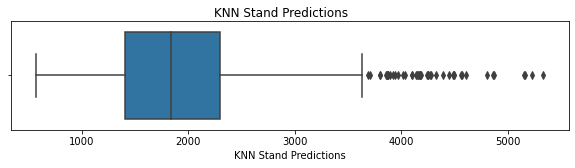

In [12]:
# defining a function for boxplots
def model_boxplots(model, data):
    """
	This function is designed to generate a boxplot for predictions to compare.
    
    PARAMETERS
	----------
	model    : Model Predictions
	data     : DataFrame of the response and categorical variables
	"""

    fig, ax = plt.subplots(figsize=(10, 2))

    sns.boxplot(x=model, data=data)

    plt.suptitle(model)
    plt.show()


# Creating boxplots for predictions results

model_boxplots('Original Sale Prices', predictions)
model_boxplots('LR Predictions', predictions)
model_boxplots('Lasso Predictions', predictions)
model_boxplots('ARD Predictions', predictions)
model_boxplots('KNN Predictions', predictions)
model_boxplots('KNN Stand Predictions', predictions)